In [1]:
from os import path

# Third-party
import astropy
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyvo.dal import TAPService
from pyia import GaiaData

import gala.coordinates as gc
import scipy.stats

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/gd1-all-ps1-red.fits')

In [4]:
# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for band in bands:
    t[band] = t[band] - t['A_{}'.format(band)]

In [5]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec, pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [6]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

In [7]:
gd1_c = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [88]:
wangle = 180*u.deg

pm_mask = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr) & 
           (g.bp_rp < 1.5*u.mag) & (g.bp_rp > 0*u.mag))

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [89]:
phi_mask_stream = ((np.abs(gd1_c.phi2)<1*u.deg) & (gd1_c.phi1.wrap_at(wangle)>-50*u.deg) & 
                   (gd1_c.phi1.wrap_at(wangle)<-10*u.deg))
phi_mask_off = ((gd1_c.phi2<-2*u.deg) & (gd1_c.phi2>-3*u.deg)) | ((gd1_c.phi2<3*u.deg) & (gd1_c.phi2>2*u.deg))

In [142]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [143]:
# distance modulus
distance_app = 7.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.5*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>17.8)
poly_main = poly[ind]

In [144]:
points = np.array([g.g - g.i, g.g]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -9*u.mas/u.yr
pm1_max = -4.5*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_max) & (gd1_c.pm_phi1_cosphi2 > pm1_min) & 
           (gd1_c.pm_phi2 < pm2_max) & (gd1_c.pm_phi2 > pm2_min))

## Define target fields

In [145]:
targets = {}
targets['phi1'] = np.array([-36.35, -39.5, -32.4, -29.8, -29.8])*u.deg
targets['phi2'] = np.array([0.2, 0.2, 1.1, 0, 1])*u.deg
Nf = len(targets['phi1'])

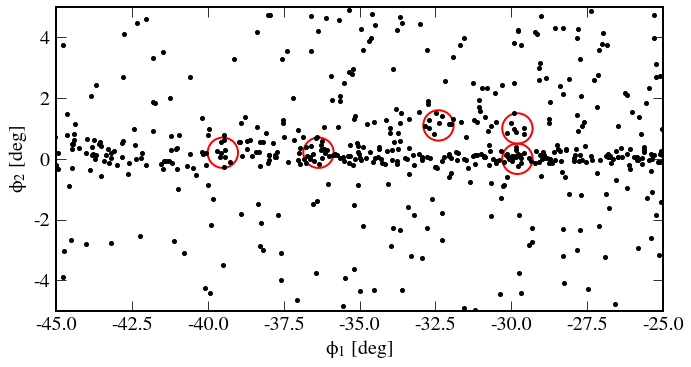

In [146]:
plt.figure(figsize=(10,8))
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask],
         'ko', ms=4)

for i in range(Nf):
        c = mpl.patches.Circle((targets['phi1'][i].value, targets['phi2'][i].value), 
                               radius=0.5, fc='none', ec='r', lw=2, zorder=2)
        plt.gca().add_patch(c)

plt.gca().set_aspect('equal')
plt.xlim(-45,-25)
plt.ylim(-5,5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

### Show overall stream

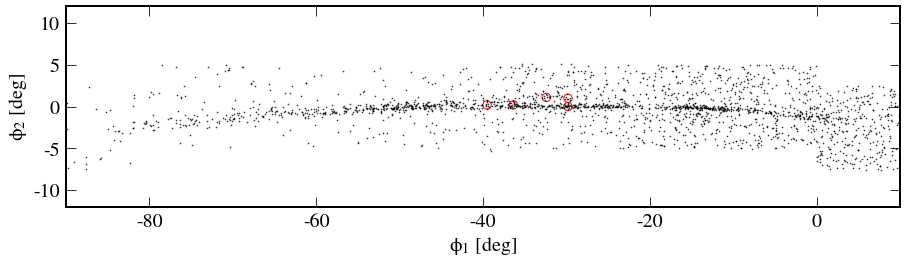

In [147]:
plt.figure(figsize=(13,10))
plt.plot(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(wangle), gd1_c.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)

for i in range(Nf):
        c = mpl.patches.Circle((targets['phi1'][i].value, targets['phi2'][i].value), 
                               radius=0.5, fc='none', ec='r', lw=1, zorder=2)
        plt.gca().add_patch(c)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.xlim(-90,10)
plt.ylim(-12,12)
plt.tight_layout()

In [148]:
targets_c = coord.SkyCoord(phi1=targets['phi1'], phi2=targets['phi2'], frame=gc.GD1)
ra_field = targets_c.icrs.ra.to_string(unit=u.hour, sep=':')
dec_field = targets_c.icrs.dec.to_string(unit=u.degree, sep=':')

tfield = Table(np.array([ra_field, dec_field]).T, names=('ra', 'dec'))
tfield.write('../data/GD1_fields_2018B.txt', format='ascii.commented_header', overwrite=True)
tfield

ra,dec
str13,str13
10:07:16.9763,39:00:21.8389
9:57:19.0754,36:32:49.2679
10:17:08.0251,42:36:11.401
10:31:11.2907,43:47:26.1864
10:27:06.9061,44:28:23.3992


## Target priorities

In [149]:
iso = Table.read('/home/ana/data/isochrones/panstarrs/mist_12.6_-1.50.cmd', 
                 format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

# distance modulus
distance_app = 7.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left_narrow = i_gi - 0.4*(i_g/28)**5
i_right_narrow = i_gi + 0.5*(i_g/28)**5
poly_narrow = np.hstack([np.array([i_left_narrow, i_g]), np.array([i_right_narrow[::-1], i_g[::-1]])]).T

i_left_wide = i_gi - 0.6*(i_g/28)**3
i_right_wide = i_gi + 0.7*(i_g/28)**3
poly_wide = np.hstack([np.array([i_left_wide, i_g]), np.array([i_right_wide[::-1], i_g[::-1]])]).T

ind = (poly_wide[:,1]<18.3) & (poly_wide[:,1]>14)
poly_low = poly_wide[ind]

ind = (poly_narrow[:,1]<20.5) & (poly_narrow[:,1]>14)
poly_med = poly_narrow[ind]

ind = (poly_narrow[:,1]<20.5) & (poly_narrow[:,1]>17.5)
poly_high = poly_narrow[ind]

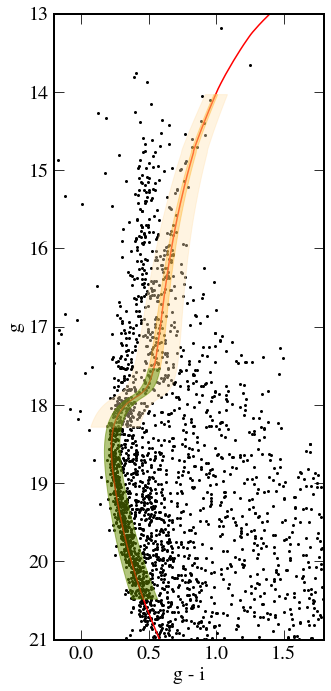

In [150]:
plt.figure(figsize=(5,10))

plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=2, alpha=1, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-')

pml = mpl.patches.Polygon(poly_low, color='moccasin', alpha=0.4, zorder=2)
plt.gca().add_artist(pml)
pmm = mpl.patches.Polygon(poly_med, color='orange', alpha=0.3, zorder=2)
plt.gca().add_artist(pmm)
pmh = mpl.patches.Polygon(poly_high, color='green', alpha=0.3, zorder=2)
plt.gca().add_artist(pmh)

plt.xlim(-0.2, 1.8)
plt.ylim(21, 13)
plt.xlabel('g - i')
plt.ylabel('g')

plt.tight_layout()

In [151]:
pm1_bmin = -12*u.mas/u.yr
pm1_bmax = 2*u.mas/u.yr
pm2_bmin = -5*u.mas/u.yr
pm2_bmax = 5*u.mas/u.yr
pm_broad_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_bmax) & (gd1_c.pm_phi1_cosphi2 > pm1_bmin) & 
           (gd1_c.pm_phi2 < pm2_bmax) & (gd1_c.pm_phi2 > pm2_bmin))

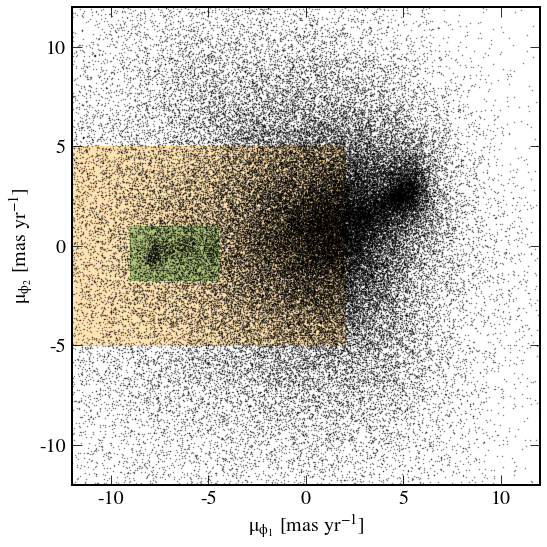

In [152]:
plt.plot(gd1_c.pm_phi1_cosphi2[phi_mask_stream].to(u.mas/u.yr), 
         gd1_c.pm_phi2[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_bmin.to(u.mas/u.yr).value, pm2_bmin.to(u.mas/u.yr).value]
rect_w = pm1_bmax.to(u.mas/u.yr).value - pm1_bmin.to(u.mas/u.yr).value
rect_h = pm2_bmax.to(u.mas/u.yr).value - pm2_bmin.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-12,12)
plt.ylim(-12,12)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.tight_layout()

## Target list

In [153]:
# check total number of stars per field
r_fov = 0.5*u.deg
mag_mask = g.g<20.5*u.mag
guide = (g.g>13*u.mag) & (g.g<15*u.mag)

for i in range(Nf):
    infield = (gd1_c.phi1.wrap_at(wangle) - targets['phi1'][i])**2 + (gd1_c.phi2 - targets['phi2'][i])**2 < r_fov**2
    print(i, np.sum(infield & pm_broad_mask & mag_mask), 
          np.sum(infield & pm_mask & mag_mask), np.sum(infield & guide))

0 304 25 28
1 297 30 32
2 288 25 24
3 296 42 29
4 286 19 14


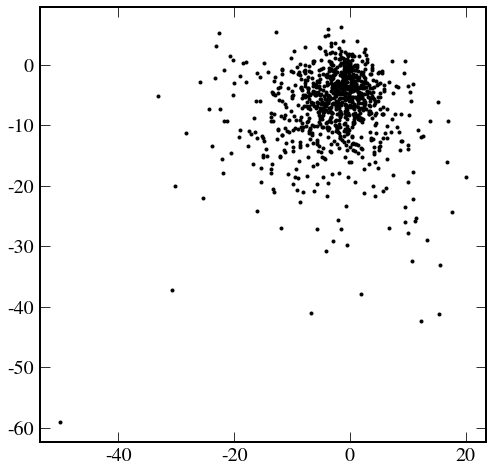

In [154]:
# plt.plot(g.g[infield]-g.i[infield],g.g[infield], 'k.')
plt.plot(g.pmra[infield],g.pmdec[infield], 'k.')
# plt.xlim(-1,3)
# plt.ylim(22,12)

In [155]:
# find ra, dec corners for querying for guide stars
cornersgd1 = astropy.coordinates.SkyCoord(phi1=np.array([-45,-45,-25,-25])*u.deg, 
                          phi2=np.array([-3,3,3,-3])*u.deg, frame=gc.GD1)
corners = cornersgd1.icrs

In [156]:
query ='''SELECT * FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag < 16 AND phot_g_mean_mag > 13 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1
'''.format(corners[0], corners[1], corners[2], corners[3])

In [157]:
print(query)

SELECT * FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag < 16 AND phot_g_mean_mag > 13 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       148.3460521663554, 30.238971765560628, 
                       142.6037429840887, 33.746595122410596, 
                       159.50134916496032, 49.32687740059019, 
                       165.54766971564723, 44.95304274266651)) = 1



In [158]:
spatial_mask = ((gd1_c.phi1.wrap_at(wangle)<-25*u.deg) & (gd1_c.phi1.wrap_at(wangle)>-45*u.deg) & 
                (gd1_c.phi2<3*u.deg) & (gd1_c.phi2>-2*u.deg))
shape_mask = spatial_mask & mag_mask & pm_broad_mask
Nout = np.sum(shape_mask)

In [159]:
points = np.array([g.g[shape_mask] - g.i[shape_mask], g.g[shape_mask]]).T

pm_mask = ((gd1_c.pm_phi1_cosphi2[shape_mask] < pm1_max) & (gd1_c.pm_phi1_cosphi2[shape_mask] > pm1_min) & 
           (gd1_c.pm_phi2[shape_mask] < pm2_max) & (gd1_c.pm_phi2[shape_mask] > pm2_min))

In [160]:
path_med = mpl.path.Path(poly_med)
path_low = mpl.path.Path(poly_low)
path_high = mpl.path.Path(poly_high)

# guide = (g.g[shape_mask]>13*u.mag) & (g.g[shape_mask]<15*u.mag)

priority4 = pm_mask
priority3 = path_low.contains_points(points) & pm_mask
priority2 = path_main.contains_points(points) & pm_mask
priority1 = path_high.contains_points(points) & pm_mask

# set up output priorities
priority = np.zeros(Nout, dtype=np.int64) + 5
# priority[guide] = -1
priority[priority4] = 4
priority[priority3] = 3
priority[priority2] = 2
priority[priority1] = 1

In [161]:
ttype = np.empty(Nout, dtype='S10')
nontarget = priority>-1
ttype[~nontarget] = 'guide'
ttype[nontarget] = 'target'

name = np.arange(Nout)

ara = coord.Angle(t['ra'][shape_mask]*u.deg)
adec = coord.Angle(t['dec'][shape_mask]*u.deg)
ra = ara.to_string(unit=u.hour, sep=':', precision=2)
dec = adec.to_string(unit=u.degree, sep=':', precision=2)

tcatalog = Table(np.array([ra, dec, name, priority, ttype, g.g[shape_mask]]).T, 
                 names=('ra', 'dec', 'object', 'rank', 'type', 'mag'), masked=True)
tcatalog['rank'].mask = ~nontarget

In [162]:
tguide = Table.read('../data/guides.fits.gz')

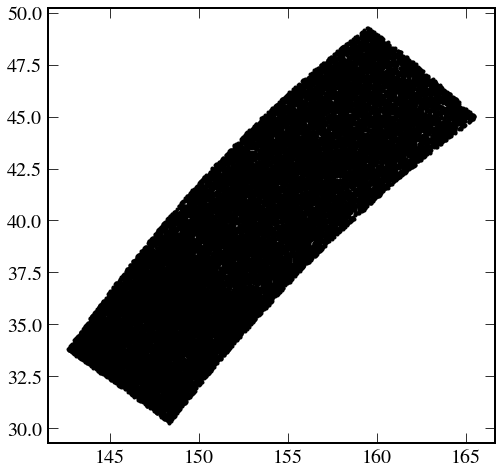

In [163]:
plt.plot(tguide['ra'], tguide['dec'],'k.')

In [164]:
# add guides
Nguide = len(tguide)
name_guides = np.arange(Nout, Nout+Nguide)

priority_guides = np.zeros(Nguide, dtype='int') - 1
nontarget_guides = priority_guides==-1

ttype_guides = np.empty(Nguide, dtype='S10')
ttype_guides[nontarget_guides] = 'guide'

ara_guides = coord.Angle(tguide['ra'])
adec_guides = coord.Angle(tguide['dec'])
ra_guides = ara_guides.to_string(unit=u.hour, sep=':', precision=2)
dec_guides = adec_guides.to_string(unit=u.degree, sep=':', precision=2)

tguides_out = Table(np.array([ra_guides, dec_guides, name_guides, priority_guides, 
                              ttype_guides, tguide['phot_g_mean_mag']]).T,
                   names=('ra', 'dec', 'object', 'rank', 'type', 'mag'), masked=True)
tguides_out['rank'].mask = ~nontarget_guides

In [165]:
tguides_out

ra,dec,object,rank,type,mag
str32,str32,str32,str32,str32,str32
10:50:44.34,43:21:43.01,35546,-1,guide,14.75761
10:56:26.22,44:09:35.21,35547,-1,guide,15.770996
10:53:11.17,43:43:58.99,35548,-1,guide,15.2277565
10:59:19.36,44:40:09.80,35549,-1,guide,14.990335
10:52:15.26,43:39:14.14,35550,-1,guide,15.904924
10:56:35.65,44:15:20.33,35551,-1,guide,13.801955
10:56:37.24,44:05:02.42,35552,-1,guide,13.969378
10:56:45.18,44:11:32.48,35553,-1,guide,13.521408
10:56:30.48,44:15:10.79,35554,-1,guide,15.965287


In [166]:
tcatalog = astropy.table.vstack([tcatalog, tguides_out])

In [167]:
tcatalog

ra,dec,object,rank,type,mag
str32,str32,str32,str32,str32,str32
9:49:42.74,30:51:13.40,0,5,target,17.04380965605378
9:49:22.49,30:53:59.74,1,5,target,19.20432175323367
9:49:24.12,30:55:16.96,2,5,target,19.618990756571293
9:49:21.94,30:57:31.67,3,5,target,19.982776761054993
9:49:23.88,30:58:46.69,4,5,target,19.558148495852947
9:49:15.58,31:00:49.94,5,5,target,19.547288186848164
9:49:49.48,30:55:28.20,6,5,target,20.002829760313034
9:49:48.72,30:56:23.82,7,5,target,20.352349817752838
9:49:39.42,30:56:38.29,8,4,target,17.44571752101183


In [168]:
tcatalog.write('../data/gd1_catalog.cat', format='ascii.fixed_width_two_line', 
               fill_values=[(astropy.io.ascii.masked, '')], delimiter='\t', overwrite=True)